<a href="https://colab.research.google.com/github/Altemir1/Machine_learning/blob/main/NN_Car_price_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NN for car price prediction

Libraries

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

Cleaning

In [4]:
import pandas as pd

cars_dataset = pd.read_csv("processes2.csv")

cars_dataset

,Unnamed: 0,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,seats,max_power (in bph),Mileage Unit,Mileage,Engine (CC)
0,0,Maruti,2014,450000,145500,Diesel,Individual,Manual,First Owner,5,74.00,kmpl,23.40,1248
1,2,Hyundai,2010,225000,127000,Diesel,Individual,Manual,First Owner,5,90.00,kmpl,23.00,1396
2,4,Hyundai,2017,440000,45000,Petrol,Individual,Manual,First Owner,5,81.86,kmpl,20.14,1197
3,7,Toyota,2011,350000,90000,Diesel,Individual,Manual,First Owner,5,67.10,kmpl,23.59,1364
4,8,Ford,2013,200000,169000,Diesel,Individual,Manual,First Owner,5,68.10,kmpl,20.00,1399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2090,6245,Maruti,2017,425000,12000,Petrol,Individual,Manual,First Owner,5,67.04,kmpl,23.10,998
2091,6246,Toyota,2014,425000,50000,Diesel,Individual,Manual,First Owner,5,67.06,kmpl,23.59,1364
2092,6249,Maruti,2011,200000,73000,Petrol,Individual,Manual,First Owner,5,46.30,kmpl,19.70,796
2093,6253,Maruti,2017,360000,80000,Petrol,Individual,Manual,First Owner,5,67.04,kmpl,20.51,998


In [ ]:
cars_dataset["Mileage Unit"].value_counts()

kmpl     2075
km/kg      20
Name: Mileage Unit, dtype: int64

Dropping unneccessary columns

In [5]:
columns_to_drop=["Unnamed: 0", "Mileage Unit"]
cars_dataset.drop(columns=columns_to_drop, inplace=True)

Preprocessing

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

object_columns = cars_dataset.select_dtypes(include=['object']).columns


label_encoder = LabelEncoder()


for column in object_columns:
    cars_dataset[column] = label_encoder.fit_transform(cars_dataset[column])


Splitting the data

In [7]:

X = cars_dataset.drop('selling_price', axis=1)
y = cars_dataset['selling_price']

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Data loader

In [19]:
from torch.utils.data import Dataset, DataLoader

class CarDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]



train_dataset = CarDataset(X_train, y_train)
test_dataset = CarDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Creating model

In [22]:
class CarPricePredictor(nn.Module):
    def __init__(self, input_size):
        super(CarPricePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


input_size = X_train.shape[1]

model = CarPricePredictor(input_size)

class CarPricePredictorExtra(nn.Module):
    def __init__(self, input_size):
        super(CarPricePredictorExtra, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x


model_extra = CarPricePredictorExtra(input_size)

class CarPricePredictorExtraUpgraded(nn.Module):
    def __init__(self, input_size):
        super(CarPricePredictorExtraUpgraded, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.bn1(self.fc1(x))))
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x

model_extra_upgraded = CarPricePredictorExtraUpgraded(input_size)


Optimizer and loss function

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time

# Assuming your model is defined as 'model_extra'
# model_extra = YourModelClass()

# Criterion and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_extra_upgraded.parameters(), lr=0.0001)

# Number of epochs to train the model
num_epochs = 3000

# Record the start time of the training
start_time = time.time()

# Training Loop
for epoch in range(num_epochs):
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.float(), labels.float()  # Ensure data is in float format

        # Forward pass: Compute predicted y by passing inputs to the model
        outputs = model_extra_upgraded(inputs)

        # Compute and print loss
        loss = criterion(outputs, labels.view(-1, 1))

        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss every epoch and log it to TensorBoard
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Record the end time of the training
end_time = time.time()

# Calculate the duration of the training
duration = end_time - start_time
print(f"Duration of training: {duration} seconds")




Epoch [1/3000], Loss: 239226672.0000
Epoch [2/3000], Loss: 212952080.0000
Epoch [3/3000], Loss: 1269447296.0000
Epoch [4/3000], Loss: 163138944.0000
Epoch [5/3000], Loss: 302455360.0000
Epoch [6/3000], Loss: 609505600.0000
Epoch [7/3000], Loss: 667293440.0000
Epoch [8/3000], Loss: 316959648.0000
Epoch [9/3000], Loss: 54895052.0000
Epoch [10/3000], Loss: 313871680.0000
Epoch [11/3000], Loss: 616064320.0000
Epoch [12/3000], Loss: 132142720.0000
Epoch [13/3000], Loss: 472998912.0000
Epoch [14/3000], Loss: 333695168.0000
Epoch [15/3000], Loss: 37389152.0000
Epoch [16/3000], Loss: 262100096.0000
Epoch [17/3000], Loss: 131883432.0000
Epoch [18/3000], Loss: 373301728.0000
Epoch [19/3000], Loss: 1147879296.0000
Epoch [20/3000], Loss: 775932992.0000
Epoch [21/3000], Loss: 1160735488.0000
Epoch [22/3000], Loss: 348014080.0000
Epoch [23/3000], Loss: 235779824.0000
Epoch [24/3000], Loss: 456045152.0000
Epoch [25/3000], Loss: 225052688.0000
Epoch [26/3000], Loss: 1540588928.0000
Epoch [27/3000], Lo

Visaualization of nn using tensorboard

In [ ]:
!tensorboard --logdir=runs

In [39]:
model_extra_upgraded.eval()
with torch.no_grad():
    total_loss = 0
    for inputs, labels in test_dataloader:
        outputs = model_extra_upgraded(inputs)
        total_loss += criterion(outputs, labels.view(-1, 1)).item()

    mean_loss = total_loss / len(test_dataloader)
    print(f'Mean Squared Error on Test Data: {mean_loss:.4f}')


Mean Squared Error on Test Data: 9678515053.7143


Average selling price of auto

In [ ]:
print(f"Mean selling price of the auto: {cars_dataset.selling_price.mean()}")

Mean selling price of the auto: 427279.87923627684


Results using different architecture types and layer configurations

1) 2 hidden layers and 64 outputs. Linear and Relu

MSE for 100 epochs : 208375349248.0000

MSE for 500 epochs: 151489019904.0000

MSE for 1000 epochs: 45333932324.5714

MSE for 2000 epochs: 9517839506.2857

MSE for 3000 epochs: 7788159049.1429; Duration: 138s

MSE for 5000 epochs: 7253937883.4286: Duration: 210s

2) 3 hidden layers and 128 outputs. Linear and Relu

MSE for 100 epochs: 20895590400.0000

MSE for 500 epochs: 6979874889.1429

MSE for 1000 epochs: 6201101056.0000

MSE for 2000 epochs: 5542507044.5714

MSE for 3000 epochs: 5432432859.4286

MSE for 5000 epochs:




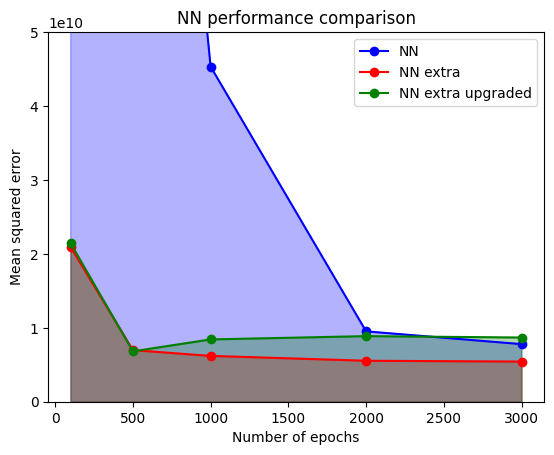

In [36]:
import matplotlib.pyplot as plt

two_layer_mse = [208375349248.0000, 151489019904.0000, 45333932324.5714, 9517839506.2857, 7788159049.142]
three_layer_mse = [20895590400.0000, 6979874889.1429, 6201101056.0000, 5542507044.5714, 5432432859.4286 ]
nn_extra_upgraded = [21415396790.8571, 6818625755.4286,  8429088036.5714, 8874410569.1429, 8685820562.2857]
number_of_epochs = [100, 500, 1000, 2000, 3000]

plt.plot(number_of_epochs, two_layer_mse, marker="o", label="NN", color="blue")
plt.plot(number_of_epochs, three_layer_mse, marker="o", label="NN extra", color="red")
plt.plot(number_of_epochs, nn_extra_upgraded, marker="o", label="NN extra upgraded", color="green")

plt.fill_between(number_of_epochs, two_layer_mse, 0, color="blue", alpha=0.3)
plt.fill_between(number_of_epochs, three_layer_mse, 0, color="red", alpha=0.3)
plt.fill_between(number_of_epochs, nn_extra_upgraded, 0, color="green", alpha=0.3)

plt.xlabel("Number of epochs")
plt.ylabel("Mean squared error")
plt.title("NN performance comparison")
plt.legend()
plt.ylim([0, 5 * pow(10, 10)])

plt.show()




Machine learning models to compare MSE due to NN

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import numpy as np

ml_models_mse = []

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100)
}


for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    ml_models_mse.append(mse)
    print(f"{name} MSE: {mse}")


Linear Regression MSE: 11644410735.27657
Decision Tree MSE: 8318787697.524661
Random Forest MSE: 4841647076.863115
SVR MSE: 47261180242.99795
Gradient Boosting MSE: 4766136405.433167


Comparing ml model and nn performance

<ipython-input-37-7fd6e4816ff6>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="model_names", y="model_mse", data=mc_sorted, palette='viridis')


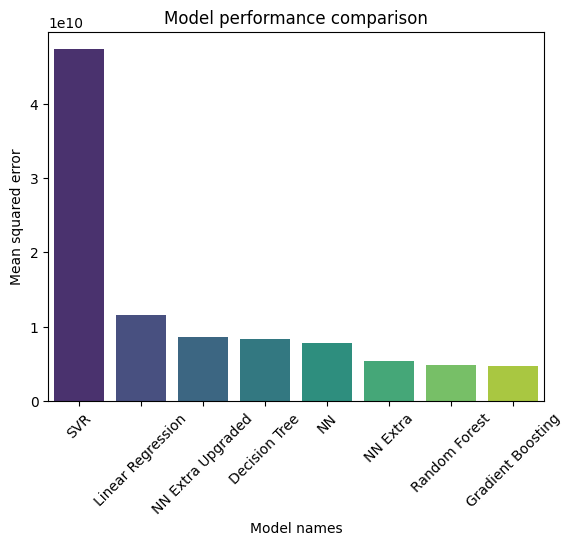

<Figure size 640x480 with 0 Axes>

In [37]:
import seaborn as sns

model_names = list(models.keys()) + ["NN", "NN Extra", "NN Extra Upgraded"]
model_mse = ml_models_mse + [7788159049.142, 5432432859.4286, 8685820562.2857]

model_comparison = {
    "model_names": model_names,
    "model_mse": model_mse
}
m_c_df = pd.DataFrame(model_comparison)

mc_sorted = m_c_df.sort_values('model_mse', ascending=False)

sns.barplot(x="model_names", y="model_mse", data=mc_sorted, palette='viridis')
plt.xlabel("Model names")
plt.ylabel("Mean squared error")
plt.title("Model performance comparison")
plt.xticks(rotation=45)
plt.show()
plt.clf()